# Error type analysis, universalized for motor or ET data of any sort
(dummyproof version)
<br>
<br>
Input: if ET: trial_extended file (processed by the data analyzer by @tzolnai: https://github.com/tzolnai/Child_ASRT_eye_tracking/tree/master/data_analysis)
if motor Eprime: file processed with ISZT
<br>
<br>
Output: 
- long data file containing response types (error_type variable), previous response types (prev_error), update (first/False/True) besides the usual (raw_dat_final)
- wide file with response type likelihoods (error_pweighted)
- wide file with previous response updates (preverr_update) or RT (preverr_RT)

In [123]:
#functions needed
import pandas as pd
import os
import glob
import numpy as np

#helper functions

#somehow this function doesnt work well.
#todo correct 

def check_variables_dict(raw_data, variables_dict):
    # Get column names from the DataFrame
    column_names = raw_data.columns.tolist()
    
    # Check if all keys in variables_dict are present in column_names
    missing_variables = [var for var in variables_dict.values() if var not in column_names]
    
    if missing_variables:
        print("The following variables in 'variables_dict' are not present in the DataFrame columns and will make your code fail miserably:")
        print(missing_variables)
        print('(if these are high, low, noPattern and such then dont worry, its cuz Orsi was lazy to fine-tune the checking function) ')
    else:
        print("All variables in 'variables_dict' are present in the DataFrame columns.")

def filter_random_epochs(raw_data, variables_dict):
    out_dat = raw_data[raw_data[variables_dict['PCode']] != variables_dict['notSeq']].copy()
    return out_dat

def is_response_LD(PCode, current_triplet, response):
    #returns True if response is LD, False if NLD
    PCode_loop = str(PCode) + str(PCode)
    if len(str(current_triplet)) <3:
        raise IndexError('Uh-oh, it seems your triplet isnt long enough if you know what I mean.')
        return None
    resp_PCode = str(current_triplet)[0] + str(response)
    if resp_PCode in PCode_loop:
        #print(f'response PCode is {resp_PCode}, pcode is {PCode}. its LD')
        return True
    else:
        #print(f'response PCode is {resp_PCode}, pcode is {PCode}. its NLD')
        return False
    
def is_response_correct(response, stimulus):
    if str(response) == str(stimulus):
        return True
    else:
        return False
    

def update_triplet(current_triplet, stim):
    if len(str(current_triplet))<3:
        return str(current_triplet) + str(stim)
    else:
        return str(current_triplet)[1:3] + str(stim)
    
def error_data_calculator(raw_data_in, variables_dict):
    #check if variables_dict matches the dataframe
    check_variables_dict(raw_data_in, variables_dict)
    #drop nonseq epochs
    raw_data = filter_random_epochs(raw_data_in, variables_dict)
       
    #init vars needed
    error_type = []
    triplet = []
    #current_epoch = 0

    for index, row in raw_data.iterrows():
        #checking if we are at a new blcok or not, and if so, erasing current triplet and save current epoch
        if int(row[variables_dict['trial']]) == 1:
            current_triplet = ''
        else:
            pass
        
        #update triplet
        current_triplet = update_triplet(current_triplet, row[variables_dict['stim']])
        triplet.append(current_triplet)
        
        if len(current_triplet)<3:
            error_type.append('none')
        else:
            if is_response_correct(row[variables_dict['response']], row[variables_dict['stim']]):
                if is_response_LD(row[variables_dict['PCode']], current_triplet, row[variables_dict['response']]):
                    error_type.append('LDC')
                else:
                    error_type.append('NLDC')
            else:
                if is_response_LD(row[variables_dict['PCode']], current_triplet, row[variables_dict['response']]):
                    error_type.append('LDE')
                else:
                    error_type.append('NLDE')

            
    raw_data['error_type'] = error_type
    raw_data['current_triplet'] = triplet
    return raw_data

## read raw data, define variables and data type

In [124]:
#set the path for the file(s) - if it does not work later, see next cell
path = 'C:\\Users\\ASUS\\BML-MEMO LAB Dropbox\\bml memo members\\Orsi_Pesthy\\_auti\\project_ASD_ET\\pilot_scipt\\data'
os.chdir(path)
files = os.listdir(os.curdir)
# what's the delimiter character in your file? most likely '\t' for txt, ',' or ';' for csv
file_sep = '\t'
#adjust to your file type:
file_type = '*.csv'
#if motor data, change to False
ET = True

#how many blocks are there in an epoch?
block_nr_per_epoch = 5

In [125]:
#run this cell only if reading the file did not work.

#1.Uncomment the next line (delete the hashtag) and run the cell
#os.getcwd()
#2.put your data file(s) to this folder on your computer
#3.copy the pathway below to the above cell to the path = ...
#4.run that cell again

In [126]:
#read the files
all_files = glob.glob(os.path.join(path, file_type))

raw_dat = pd.concat((pd.read_csv(f, sep = file_sep) for f in all_files), ignore_index=True)

In [127]:
#inspect the data file. Does it look good? 
raw_dat.head()
#sure it does, this pretty little thing

,computer_name,monitor_width_pixel,monitor_height_pixel,subject_group,subject_number,subject_sex,subject_age,asrt_type,PCode,session,...,trial_type_pr,triplet_type_hl,stimulus,RT (ms),last_AOI_before_stimulus,repetition,trill,high_low_learning,has_anticipation,has_learnt_anticipation
0,Laposka,1920,1080,NaN,902,male,31,noASRT,noPattern,1,...,random,none,2,"611,853",4,none,none,none,none,none
1,Laposka,1920,1080,NaN,902,male,31,noASRT,noPattern,1,...,random,none,1,"250,985",3,False,none,none,True,none
2,Laposka,1920,1080,NaN,902,male,31,noASRT,noPattern,1,...,random,none,1,0,1,True,False,high,False,False
3,Laposka,1920,1080,NaN,902,male,31,noASRT,noPattern,1,...,random,none,2,"325,0",1,False,False,low,False,False
4,Laposka,1920,1080,NaN,902,male,31,noASRT,noPattern,1,...,random,none,4,"955,618",2,False,False,high,False,False


In [128]:
#select the cols you need. First, let's print it:
raw_dat.columns

Index(['computer_name', 'monitor_width_pixel', 'monitor_height_pixel',
       'subject_group', 'subject_number', 'subject_sex', 'subject_age',
       'asrt_type', 'PCode', 'session', 'epoch', 'block', 'trial',
       'frame_rate', 'frame_time', 'frame_sd', 'stimulus_color',
       'trial_type_pr', 'triplet_type_hl', 'stimulus', 'RT (ms)',
       'last_AOI_before_stimulus', 'repetition', 'trill', 'high_low_learning',
       'has_anticipation', 'has_learnt_anticipation'],
      dtype='object')

In [129]:
#copy the name of the variables you need here. 
#You definitely will need: subject number, PCode, epoch/blcok, trial nr, triplet type (H/L), stimulus, and your dependent var (RT or last AOI)
list_cols = ['subject_number', 'PCode', 'epoch', 'block', 'trial','triplet_type_hl', 'stimulus', 'RT (ms)',
       'last_AOI_before_stimulus', 'repetition', 'trill', 'high_low_learning',
       'has_anticipation', 'has_learnt_anticipation']
#now, let's drop the cols we don't need shall we
raw_dat2 = raw_dat[list_cols]

In [130]:
#adding colum for error type
raw_dat2['error_type'] = pd.Series(dtype='str')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\487720172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dat2['error_type'] = pd.Series(dtype='str')


In [131]:
#did it work?
raw_dat2.columns
#ofc it did you doubtful little one

Index(['subject_number', 'PCode', 'epoch', 'block', 'trial', 'triplet_type_hl',
       'stimulus', 'RT (ms)', 'last_AOI_before_stimulus', 'repetition',
       'trill', 'high_low_learning', 'has_anticipation',
       'has_learnt_anticipation', 'error_type'],
      dtype='object')

## Some extra steps if you use Eprime

In [ ]:
#NEEDED ONLY IF THERE WERE MORE THAN ONE SESSIONS
#organize data by participant (not by session)
raw_dat2 = raw_dat2.sort_values(by = ["Subject", "epoch"]).reset_index(drop=True)

In [ ]:
#we will need some extra steps to prep your data for what's coming
#what's the name of the block variable?
block = 'Block'

#adding a trial var:
def get_trial_nr(eprime_output_data, block):
    trial = []
    trial_nr = 1
    prev_block = "init"
    for index, row in eprime_output_data.iterrows():
        if index == 0:
            trial.append(trial_nr)
        elif prev_block == row[block]:
            trial.append(trial_nr)
        else:
            trial_nr = 1
            trial.append(trial_nr)
        prev_block = row[block]
        trial_nr += 1
        
    return trial

In [ ]:
raw_dat2["trial"] = get_trial_nr(raw_dat2, block)

In [ ]:
# Getting the actual PCodes
PCode_dict = {"1": "3412", "4": "3421", "5": "3142", "2": "3124", "6": "3214", "3": "3241"}

def recode_pcode(eprime_output_data, PCode_dict):
    PCode = []
    for index, row in eprime_output_data.iterrows():
        row_pcode = str(row["PCode"])
        PCode.append(PCode_dict[row_pcode])
    return PCode

In [ ]:
raw_dat2["PCodes"] = recode_pcode(raw_dat2,PCode_dict)

In [ ]:
#recoding responses to events - ADJUST to QWERTZ or QWERTY if needed
##ATTENTION: the var names are hardcoded here, adjust if needed (sorry, I was in a hurry coding this)
resp_dict = {
    "z": 1,
    "c": 2,
    "b": 3,
    "m": 4,
}

def recode_resp(eprime_output_data, resp_dict):
    response = []
    for index, row in eprime_output_data.iterrows():
        row_resp = str(row["firstRESP"])
        if row_resp not in resp_dict:
            response.append("ERROR")
        else:
            response.append(resp_dict[row_resp])
    return response


In [ ]:
raw_dat2["response"] = recode_resp(raw_dat2,resp_dict)

In [ ]:
raw_dat2.head()

## calculating and addig error type to the dataframe

In [132]:
#let's get down to business now and calculate the error types

#define your var names: change the key (the word after the colons) to the name the given thing is called in your data
variables = dict({
    #the location of the appearing stim:
    'stim': 'stimulus',
    #H L triplets:
    'triplet_type': 'triplet_type_hl',
    #participant's response (e.g., last AOI in eye-tracking data, or button the participant pressed in the motor version):
    'response': 'last_AOI_before_stimulus',
    #how are random stimuli in the beginning of blocks marked?
    'rando': 'none',
    #the string for high triplets
    'H': 'high',
    #and low?
    'L': 'low',
    #and blockstarter randoms?
    'X': 'none',
    #which var is a string of the sequence (e.g., '1234')?
    'PCode': 'PCode',
    #time unit (epoch or block)
    'epoch': 'epoch',
    #string marking nonpattern blocks:
    'notSeq': 'noPattern',
    #trial nr
    'trial': 'trial',
    'error_type': 'error_type',
    #dependent var
    'dep': 'RT (ms)',
    'TT': 'triplet_type_hl',
    'sub': 'subject_number'
})

In [133]:
#get data
dat_errors = error_data_calculator(raw_dat2, variables)

The following variables in 'variables_dict' are not present in the DataFrame columns and will make your code fail miserably:
['none', 'high', 'low', 'none', 'noPattern']
(if these are high, low, noPattern and such then dont worry, its cuz Orsi was lazy to fine-tune the checking function) 


In [134]:
dat_errors.head()
#everything came together so nicely!

,subject_number,PCode,epoch,block,trial,triplet_type_hl,stimulus,RT (ms),last_AOI_before_stimulus,repetition,trill,high_low_learning,has_anticipation,has_learnt_anticipation,error_type,current_triplet
425,902,1432,2,6,1,none,4,"696,777",1,none,none,none,none,none,none,4
426,902,1432,2,6,2,none,1,"266,423",1,False,none,none,True,none,none,41
427,902,1432,2,6,3,low,2,"352,544",1,False,False,low,False,False,NLDE,412
428,902,1432,2,6,4,low,1,"283,604",2,False,True,low,False,False,NLDE,121
429,902,1432,2,6,5,low,4,"376,962",1,False,False,low,False,False,LDE,214


In [33]:
#optional: write data to excel
#uncomment the next line and run the cell:
#dat_errors.to_excel('dat_errors.xlsx')
#if permission denied error, close the xlsx file first, run it again

## calculating prior updates

In [135]:
def was_there_an_update(tri_dict, row, variables_dict):
    current = str(row["current_triplet"])
    if current not in tri_dict:
        raise ValueError(f'Man, we dont have any {current} in the triplet dictionary, check the is_prior_updated_function or dunno')
        return None
    elif tri_dict[current][0] == row[variables_dict['response']]:
        #there was no update
        return False
    else:
        return True

In [136]:
def prior_update_type(row, tri_dict, variables_dict):
    resp_LD = is_response_LD(row[variables_dict['PCode']],row['current_triplet'],row[variables_dict['response']] )
    was_updated = was_there_an_update(tri_dict, row, variables_dict)
    if resp_LD and was_updated:
        return 'LD_UP'
    elif resp_LD and not was_updated:
        return 'LD_SAME'
    #if the prev response was NLD and it was updated to a... what?
    elif 'NLD' in tri_dict[row['current_triplet']][1]:
        if str(row[variables_dict['response']]) == str(tri_dict[row['current_triplet']])[0]:
            return 'NLD_SAME'
        else:
            return 'EXPL_NLD_UP'
    elif 'NLD' not in tri_dict[row['current_triplet']][1] and not resp_LD:
        return 'WRONG_NLD_UP'


In [137]:
def calculate_update_vars(dat_with_errors, variables_dict):
    #init target vars
    update = []
    trials_since_triplet = []
    LD_update = []
    prev_errortype = []
    current_subject = ''
    triplets = dict()
    

    
    for index, row in dat_with_errors.iterrows():
        
        #vars to make code more readable:
        if str(current_subject) != str(row[variables_dict['sub']]):
            triplets = dict()
            print(f'current_subject {current_subject} updated to {row[variables_dict["sub"]]}')
            current_subject = str(row[variables_dict["sub"]])
        current_triplet = str(row["current_triplet"])
        response = row[variables_dict["response"]]
        
        if len(current_triplet)<3:
            update.append('none')
            trials_since_triplet.append('none')
            LD_update.append('none')
            prev_errortype.append('none')
        
        elif current_triplet not in triplets:
            triplets[current_triplet] = [response, row['error_type'], index]
            #print(f'current triplet is {current_triplet} at sub {row["subject_number"]}')
            #print(f'Im adding {triplets[current_triplet]} to the dict')
            update.append('first')
            trials_since_triplet.append('none')
            LD_update.append('first')
            prev_errortype.append('first')

        else:
            #print(f'triplet {current_triplet} in dict')
            update.append(was_there_an_update(triplets, row, variables_dict))
            trials_since_triplet.append(index - triplets[current_triplet][2])
            LD_update.append(prior_update_type(row, triplets, variables_dict))
            prev_errortype.append(triplets[current_triplet][1])
            #print(f'Im adding {triplets[current_triplet]} to the dict')
            triplets[current_triplet] = [response, row['error_type'], index]
            
    #print(triplets)
    dat_with_errors['update'] = update
    dat_with_errors['trials_since_triplet'] = trials_since_triplet
    dat_with_errors['type_of_update'] = LD_update
    dat_with_errors['prev_error'] = prev_errortype
    
    return dat_with_errors

In [138]:
raw_dat_final = calculate_update_vars(dat_errors, variables).reset_index()

current_subject  updated to 902
current_subject 902 updated to 903
current_subject 903 updated to 904
current_subject 904 updated to 905
current_subject 905 updated to 906
current_subject 906 updated to 908
current_subject 908 updated to 909
current_subject 909 updated to 911
current_subject 911 updated to 912
current_subject 912 updated to 913
current_subject 913 updated to 914
current_subject 914 updated to 915
current_subject 915 updated to 916
current_subject 916 updated to 917
current_subject 917 updated to 918
current_subject 918 updated to 919
current_subject 919 updated to 921
current_subject 921 updated to 923
current_subject 923 updated to 925
current_subject 925 updated to 926
current_subject 926 updated to 927
current_subject 927 updated to 928
current_subject 928 updated to 929
current_subject 929 updated to 930
current_subject 930 updated to 932
current_subject 932 updated to 933
current_subject 933 updated to 934
current_subject 934 updated to 935
current_subject 935 upd

In [139]:
#this one is needed for ET data produced by the ET zero code only!
raw_dat_final['RT (ms)'] = pd.to_numeric(raw_dat_final['RT (ms)'].str.replace(',', '.'))

In [140]:
raw_dat_final.head()

,index,subject_number,PCode,epoch,block,trial,triplet_type_hl,stimulus,RT (ms),last_AOI_before_stimulus,...,trill,high_low_learning,has_anticipation,has_learnt_anticipation,error_type,current_triplet,update,trials_since_triplet,type_of_update,prev_error
0,425,902,1432,2,6,1,none,4,696.777,1,...,none,none,none,none,none,4,none,none,none,none
1,426,902,1432,2,6,2,none,1,266.423,1,...,none,none,True,none,none,41,none,none,none,none
2,427,902,1432,2,6,3,low,2,352.544,1,...,False,low,False,False,NLDE,412,first,none,first,first
3,428,902,1432,2,6,4,low,1,283.604,2,...,True,low,False,False,NLDE,121,first,none,first,first
4,429,902,1432,2,6,5,low,4,376.962,1,...,False,low,False,False,LDE,214,first,none,first,first


In [294]:
#optional: write to excels
raw_dat_final.to_csv('long_dat_M23.csv')

## Creating wide data for ANOVAs
this part is a bit of a mess, todo: organize it a bit, add comments etc.

In [167]:
def crosstab_data(rows, list_of_columns):
    #for now it works only with 1-1 index and col
    if type(rows) == list:
        raise TypeError("Sorry, this pitty excuse for a function can handle only 1 variable as column. Don't make it a list.")
    data_out = pd.crosstab(index = rows, columns = list_of_columns)
    data_out.columns = [' '.join(str(col)).strip() for col in data_out.columns.values]
    data_out.reset_index(inplace=True)
    data_out.columns = data_out.columns.str.replace("[()'', ]", "")
    data_out.columns = data_out.columns.str.replace("C", "C_")
    data_out.columns = data_out.columns.str.replace("E", "E_")
    data_out.replace('', np.nan, inplace=True)
    data_out.dropna(axis = 0, inplace=True)
    return data_out

In [145]:
def pivot_data(data_in, outcome_var, indeces, cols, aggfunction, group_file = None):
    data_out = pd.pivot_table(data_in, values = outcome_var, index = indeces, columns = cols, aggfunc = aggfunction)
    data_out.columns = [' '.join(str(col)).strip() for col in data_out.columns.values]
    data_out.reset_index(inplace=True)
    data_out.columns = data_out.columns.str.replace("[()'', ]", "")
    if group_file is not None:
        data_out = pd.merge(data_out, group_file, on='Subject', how='outer')
    data_out.replace('', np.nan, inplace=True)
    data_out.dropna(axis = 0, inplace=True)
    return data_out

### only for ET data

In [146]:
#filter zero RTs and block-starting nones
raw_dat_filt = raw_dat_final.loc[raw_dat_final[variables['dep']] != 0].reset_index()
raw_dat_filt = raw_dat_filt[raw_dat_filt[variables['TT']] != 'none'].reset_index(drop = True)


### for all

In [293]:
#optional: write to excels
raw_dat_filt.to_csv('long_0RT_none_filtM23.csv')

### creating the Pweighted probability data (and graphs)

#### simple error counts

In [168]:
error_dat_filt = crosstab_data(raw_dat_filt[variables['sub']], [raw_dat_filt['error_type'], raw_dat_filt[variables['epoch']]])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\3657125136.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


In [169]:
error_dat_filt.head()

,subject_number,LDC_2,LDC_3,LDC_4,LDC_5,LDC_6,LDC_7,LDC_8,LDE_2,LDE_3,...,NLDC_6,NLDC_7,NLDC_8,NLDE_2,NLDE_3,NLDE_4,NLDE_5,NLDE_6,NLDE_7,NLDE_8
0,902,34,28,41,36,30,33,17,30,42,...,13,12,17,283,277,281,264,261,264,251
1,903,57,38,59,51,63,47,51,45,46,...,29,17,19,250,256,269,255,245,250,247
2,904,39,52,48,47,56,45,47,40,57,...,21,33,19,267,263,274,271,273,269,270
3,905,60,57,66,42,45,55,47,40,44,...,32,28,21,270,274,250,279,263,282,279
4,906,34,35,14,20,15,19,18,41,42,...,8,16,8,285,275,273,279,279,248,266


In [172]:
#unfiltered:
error_dat = crosstab_data(raw_dat_final[variables['sub']], [raw_dat_final['error_type'], raw_dat_final[variables['epoch']]])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\3657125136.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


In [173]:
error_dat_filt.head() 

,subject_number,LDC_2,LDC_3,LDC_4,LDC_5,LDC_6,LDC_7,LDC_8,LDE_2,LDE_3,...,NLDC_6,NLDC_7,NLDC_8,NLDE_2,NLDE_3,NLDE_4,NLDE_5,NLDE_6,NLDE_7,NLDE_8
0,902,34,28,41,36,30,33,17,30,42,...,13,12,17,283,277,281,264,261,264,251
1,903,57,38,59,51,63,47,51,45,46,...,29,17,19,250,256,269,255,245,250,247
2,904,39,52,48,47,56,45,47,40,57,...,21,33,19,267,263,274,271,273,269,270
3,905,60,57,66,42,45,55,47,40,44,...,32,28,21,270,274,250,279,263,282,279
4,906,34,35,14,20,15,19,18,41,42,...,8,16,8,285,275,273,279,279,248,266


#### error percentages

In [174]:
trial_nr_per_block = max(raw_dat_final['trial'])
trial_nr_per_epoch = trial_nr_per_block * block_nr_per_epoch

In [175]:
cols = error_dat.columns
error_perc_dat = pd.DataFrame(columns=cols)

In [176]:
# create the % file
error_perc_dat[variables['sub']] = error_dat[variables['sub']]
for col in cols[1:]:
    error_perc_dat[col] = error_dat[col]/trial_nr_per_epoch

In [177]:
error_perc_dat.head()

,subject_number,LDC_2,LDC_3,LDC_4,LDC_5,LDC_6,LDC_7,LDC_8,LDE_2,LDE_3,...,NLDE_6,NLDE_7,NLDE_8,none2,none3,none4,none5,none6,none7,none8
0,902,0.155294,0.145882,0.164706,0.152941,0.152941,0.152941,0.152941,0.070588,0.098824,...,0.614118,0.621176,0.590588,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529
1,903,0.181176,0.188235,0.171765,0.150588,0.200000,0.178824,0.195294,0.105882,0.108235,...,0.576471,0.588235,0.581176,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529
2,904,0.155294,0.141176,0.150588,0.160000,0.155294,0.138824,0.141176,0.094118,0.134118,...,0.642353,0.632941,0.635294,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529
3,905,0.157647,0.143529,0.174118,0.127059,0.138824,0.141176,0.138824,0.094118,0.103529,...,0.618824,0.663529,0.656471,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529
4,906,0.127059,0.150588,0.160000,0.148235,0.138824,0.176471,0.148235,0.096471,0.098824,...,0.656471,0.583529,0.625882,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529,0.023529


### now the error likelihoods

This section will devide the percentages with the probability of the given response on chance-level

In [178]:
error_probabilities = {
    "LDC": 0.15625,
    "LDE": 0.09375,
    "NLDE": 0.65625,
    "NLDC": 0.09375
}

In [181]:
error_pweighted = pd.DataFrame()
for colname, col in error_perc_dat.items():
    if colname == variables['sub']:
        error_pweighted[colname] = error_perc_dat[colname]
    elif variables['X'] in colname:
        pass
    else:
        for key in error_probabilities:
            if key in colname and len(colname) == len(key)+2:
                #(this latter bit cuz LDE is in NLDE too :/ )
                error_pweighted[colname] = error_perc_dat[colname]/error_probabilities[key]
            else:
                pass
            

In [182]:
error_pweighted.head()

,subject_number,LDC_2,LDC_3,LDC_4,LDC_5,LDC_6,LDC_7,LDC_8,LDE_2,LDE_3,...,NLDC_6,NLDC_7,NLDC_8,NLDE_2,NLDE_3,NLDE_4,NLDE_5,NLDE_6,NLDE_7,NLDE_8
0,902,0.993882,0.933647,1.054118,0.978824,0.978824,0.978824,0.978824,0.752941,1.054118,...,0.978824,0.978824,1.104314,1.014678,0.993165,1.007507,0.946555,0.935798,0.946555,0.899944
1,903,1.159529,1.204706,1.099294,0.963765,1.280000,1.144471,1.249882,1.129412,1.154510,...,0.953725,0.702745,0.803137,0.896359,0.917871,0.964482,0.914286,0.878431,0.896359,0.885602
2,904,0.993882,0.903529,0.963765,1.024000,0.993882,0.888471,0.903529,1.003922,1.430588,...,0.727843,1.129412,0.778039,0.957311,0.942969,0.982409,0.971653,0.978824,0.964482,0.968067
3,905,1.008941,0.918588,1.114353,0.813176,0.888471,0.903529,0.888471,1.003922,1.104314,...,1.029020,0.803137,0.828235,0.968067,0.982409,0.896359,1.000336,0.942969,1.011092,1.000336
4,906,0.813176,0.963765,1.024000,0.948706,0.888471,1.129412,0.948706,1.029020,1.054118,...,0.978824,1.229804,1.029020,1.021849,0.985994,0.978824,1.000336,1.000336,0.889188,0.953725


In [292]:
error_pweighted.to_csv("ANOVA_pweighted_M23.csv")

## plot this error likelihood stuff

To do: integrate the extra melt into the function, now it's sort of a mess, I patched up two already existing codes and tailored it a bit

In [207]:
def get_wide_to_long(wide_dat_in, stubs, i = "Subject", j = "Epoch", sep="_"):
    long_dat_out = pd.wide_to_long(wide_dat_in, stubs, i, j, sep)
    long_dat_out.columns = [' '.join(str(col)).strip() for col in long_dat_out.columns.values]
    long_dat_out.reset_index(inplace=True)
    long_dat_out.columns = long_dat_out.columns.str.replace("[()'',_ ]", "")
    long_dat_out.replace('', np.nan, inplace=True)
    long_dat_out.dropna(axis = 0, inplace=True)
    return long_dat_out

import seaborn as sns

In [209]:
#create long data
long_error_likelihood = get_wide_to_long(error_pweighted, stubs=["LDC", "LDE", "NLDC", "NLDE"], i=['subject_number'], j='epoch', sep='_')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\3394471637.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  long_dat_out.columns = long_dat_out.columns.str.replace("[()'',_ ]", "")


In [235]:
melted_df = pd.melt(long_error_likelihood, id_vars=['subjectnumber', 'epoch'], var_name='Response type', value_name='likelihood')


In [311]:
melted_df["error"] = melted_df["Response type"].apply(lambda x: True if "E" in x else False)

In [312]:
palette = {"#EDDD09", "#FF9900", "#008EC0", "#006600"}


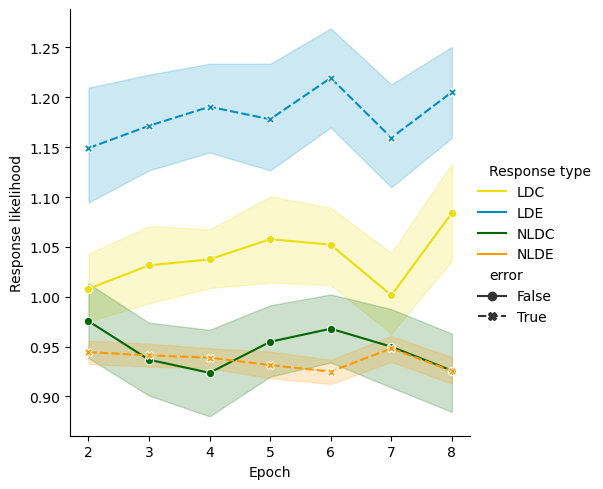

In [313]:
resplike = sns.relplot(
    data=melted_df,
    x="epoch",
    y="likelihood",
    hue="Response type",
    kind='line',
    marker='o',
    palette=palette,
    style="error",  # Use "error_type" for the line styles
    markers=True,
)

# Customize labels and legend
resplike.set(xlabel="Epoch", ylabel="Response likelihood")

# Show the plot
#resplike.show()

## preverror pivots

In [258]:
raw_dat_final = raw_dat_final[raw_dat_final[variables['TT']] != 'none'].reset_index(drop = True)

In [270]:
raw_dat_final['update_nr'] = raw_dat_final['update'].replace({"first": "", False: 0, True: 1})

In [287]:
raw_dat_final.replace('', np.nan, inplace=True)
raw_dat_final_for_update = raw_dat_final.dropna(subset=['update_nr']).reset_index(drop=True)

In [288]:
raw_dat_final_for_update.head(70)

,index,subject_number,PCode,epoch,block,trial,triplet_type_hl,stimulus,RT (ms),last_AOI_before_stimulus,...,high_low_learning,has_anticipation,has_learnt_anticipation,error_type,current_triplet,update,trials_since_triplet,type_of_update,prev_error,update_nr
0,445,902,1432,2,6,21,high,3,388.587,1,...,high,False,False,NLDE,413,True,13,EXPL_NLD_UP,NLDE,1.0
1,446,902,1432,2,6,22,high,4,882.522,2,...,high,True,False,NLDE,134,True,13,EXPL_NLD_UP,NLDE,1.0
2,448,902,1432,2,6,24,high,3,776.800,1,...,high,True,False,NLDE,433,False,8,EXPL_NLD_UP,NLDE,0.0
3,450,902,1432,2,6,26,high,2,0.000,2,...,high,True,True,LDC,342,True,16,LD_UP,NLDE,1.0
4,453,902,1432,2,6,29,high,2,304.234,1,...,high,False,False,NLDE,312,False,11,EXPL_NLD_UP,NLDE,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,542,902,1432,2,7,33,low,1,0.000,1,...,low,False,False,NLDC,111,False,49,EXPL_NLD_UP,NLDC,0.0
66,543,902,1432,2,7,34,high,4,408.173,1,...,high,False,False,NLDE,114,False,49,EXPL_NLD_UP,NLDE,0.0
67,545,902,1432,2,7,36,high,3,566.073,1,...,high,False,False,NLDE,413,True,57,EXPL_NLD_UP,NLDE,1.0
68,546,902,1432,2,7,37,low,1,282.829,1,...,low,True,False,NLDC,131,True,57,EXPL_NLD_UP,NLDE,1.0


In [300]:
preverr_update = pivot_data(raw_dat_final, "update_nr", "subject_number", ["prev_error", "epoch"], np.mean, group_file = None)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\2273175297.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


In [295]:
preverr_update.head()

,subject_number,LDC2,LDC3,LDC4,LDC5,LDC6,LDC7,LDC8,LDE2,LDE3,...,NLDC6,NLDC7,NLDC8,NLDE2,NLDE3,NLDE4,NLDE5,NLDE6,NLDE7,NLDE8
0,902,0.475410,0.555556,0.380282,0.390625,0.375000,0.575758,0.390625,0.380952,0.333333,...,0.400000,0.428571,0.295455,0.439024,0.440860,0.381818,0.407407,0.396947,0.411321,0.385214
1,903,0.534247,0.525641,0.479452,0.530303,0.392857,0.547945,0.500000,0.448276,0.568627,...,0.390244,0.709677,0.760000,0.579439,0.594488,0.449814,0.519231,0.524793,0.552000,0.666667
2,904,0.612903,0.661290,0.603175,0.537313,0.580645,0.677419,0.677966,0.629630,0.411765,...,0.586207,0.577778,0.617647,0.546610,0.551724,0.525180,0.543726,0.534050,0.564885,0.543796
3,905,0.571429,0.593220,0.520548,0.542373,0.649123,0.600000,0.516667,0.655172,0.611111,...,0.540541,0.641026,0.705882,0.575630,0.574545,0.616601,0.582707,0.600000,0.597826,0.574545
4,906,0.680000,0.596774,0.228571,0.261538,0.368421,0.402778,0.384615,0.678571,0.533333,...,0.305556,0.413043,0.425532,0.598394,0.527473,0.200730,0.284173,0.298561,0.398467,0.345098


In [296]:
preverr_update.to_csv("ANOVA_preverr_update_M23.csv")

In [301]:
preverr_RT = pivot_data(raw_dat_filt, "RT (ms)", "subject_number", ["prev_error", "epoch"], np.median, group_file = None)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_29324\2273175297.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data_out.columns = data_out.columns.str.replace("[()'', ]", "")


In [302]:
preverr_RT.head()

,subject_number,LDC2,LDC3,LDC4,LDC5,LDC6,LDC7,LDC8,LDE2,LDE3,...,NLDC8,NLDE2,NLDE3,NLDE4,NLDE5,NLDE6,NLDE7,NLDE8,first2,first3
0,902,326.4220,322.4275,308.5870,355.6155,353.2815,343.1740,325.170,376.382,382.3370,...,387.6080,366.1370,365.2890,375.2715,397.7040,372.2405,366.5080,360.207,366.837,291.1540
2,904,319.0650,308.4560,307.9730,333.0970,307.3105,335.0795,361.966,387.295,349.6650,...,345.9910,361.4290,333.2310,333.7870,349.8420,341.7365,349.8910,349.908,366.424,337.7335
3,905,314.8770,307.3390,302.7160,320.1750,307.0755,308.1670,308.428,334.698,312.8920,...,319.9140,324.6545,320.9215,322.5750,324.3960,316.4930,317.5320,316.922,319.077,416.0855
5,908,324.4320,308.6730,329.0475,312.1880,366.5770,355.3025,316.840,344.996,362.4795,...,392.9370,322.1430,325.0455,333.1005,325.0205,325.4660,325.7085,317.333,324.792,346.0500
6,909,350.0535,316.5830,325.4700,316.7635,309.7945,313.5000,313.459,316.784,330.1415,...,317.6745,319.5885,334.4540,324.2225,316.6480,314.3010,319.9320,316.077,325.724,282.6450


In [303]:
preverr_RT.to_csv("ANOVA_preverr_RT_M23.csv")

## graphs of previous resp thingies

In [309]:
raw_dat_final_for_update["prev_is_err"] = raw_dat_final_for_update["prev_error"].apply(lambda x: True if "E" in x else False)

In [310]:
raw_dat_final_for_update.head()

,index,subject_number,PCode,epoch,block,trial,triplet_type_hl,stimulus,RT (ms),last_AOI_before_stimulus,...,has_anticipation,has_learnt_anticipation,error_type,current_triplet,update,trials_since_triplet,type_of_update,prev_error,update_nr,prev_is_err
0,445,902,1432,2,6,21,high,3,388.587,1,...,False,False,NLDE,413,True,13,EXPL_NLD_UP,NLDE,1.0,True
1,446,902,1432,2,6,22,high,4,882.522,2,...,True,False,NLDE,134,True,13,EXPL_NLD_UP,NLDE,1.0,True
2,448,902,1432,2,6,24,high,3,776.800,1,...,True,False,NLDE,433,False,8,EXPL_NLD_UP,NLDE,0.0,True
3,450,902,1432,2,6,26,high,2,0.000,2,...,True,True,LDC,342,True,16,LD_UP,NLDE,1.0,True
4,453,902,1432,2,6,29,high,2,304.234,1,...,False,False,NLDE,312,False,11,EXPL_NLD_UP,NLDE,0.0,True


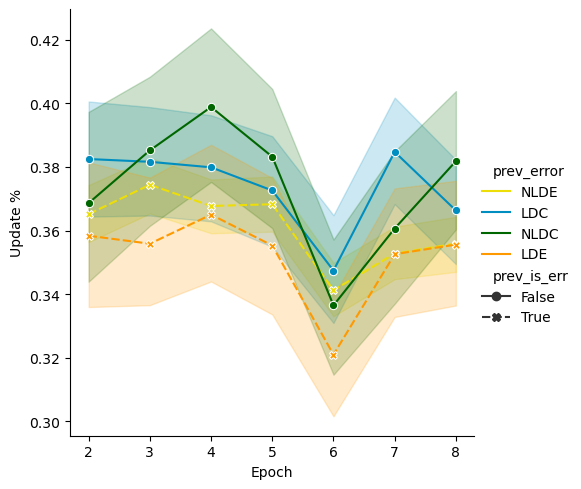

In [314]:
# data i need: raw_dat_final_for_update & raw_dat_filt

resplike = sns.relplot(
    data=raw_dat_final_for_update,
    x="epoch",
    y="update_nr",
    hue="prev_error",
    kind='line',
    marker='o',
    palette=palette,
    style="prev_is_err", 
    markers=True,
)

# Customize labels and legend
resplike.set(xlabel="Epoch", ylabel="Update %")

# Show the plot
#resplike.show()


In [315]:
raw_dat_filt["prev_is_err"] = raw_dat_filt["prev_error"].apply(lambda x: True if "E" in x else False)

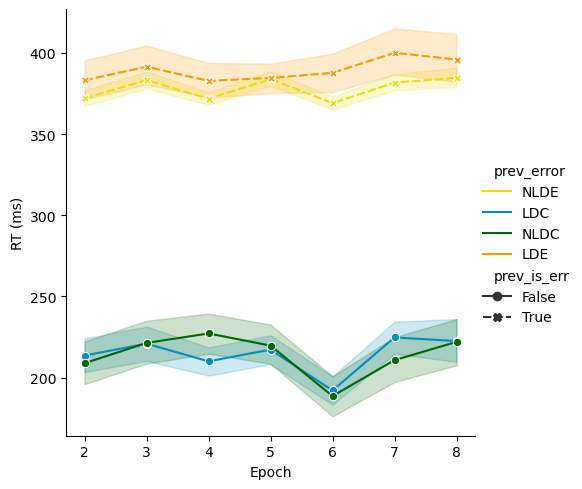

In [316]:
# data i need: raw_dat_final_for_update & raw_dat_filt

resplike = sns.relplot(
    data=raw_dat_final_for_update,
    x="epoch",
    y="RT (ms)",
    hue="prev_error",
    kind='line',
    marker='o',
    palette=palette,
    style="prev_is_err", 
    markers=True,
)

# Customize labels and legend
resplike.set(xlabel="Epoch", ylabel="RT (ms)")

# Show the plot
#resplike.show()


# Congrats! You are all set. 